In [402]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import random 
import time

In [403]:
carpeta = (os.getcwd()+'/tc02Data/')

# Nombres de los archivos: yeast_(...).txt
archivos = ['Y2H','AP-MS','LIT','LIT_Reguly']

# Lista donde se van a ir agregando los grafos en el orden de los archivos
Gs = []

for j,archivo in enumerate(archivos):
    data = pd.read_csv(carpeta+'yeast_'+archivo+'.txt', sep='\t', header=None)
    
    G = nx.Graph()
    
    for i in range(len(data)):
        G.add_edges_from([(data[0][i],data[1][i])])
    Gs.append(G)

# El último archivo, LIT_Reguly, es el único que tiene encabezado
# Quise poner header automático pero devuelve un error, así que elimino lo que sobra a lo bruto
Gs[3].remove_node("Bait gene/protein")
Gs[3].remove_node("Hit gene/protein")


In [404]:
# Proteinas esenciales
data_ess = pd.read_csv(carpeta+'Essential_ORFs_paperHe.txt', sep='\t', header=0,skipfooter=4,usecols=[1])

# Para eliminar los espacios en los nombres de las proteinas
data_ess['ORF_name'] = data_ess['ORF_name'].map(lambda x: x.strip())

ess = data_ess["ORF_name"].tolist()
del ess[0] # como antes, elimino el encabezado

# ess es la lista de proteinas esenciales

C:\Users\Lucio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [405]:
def fig3(G,ess):      
    
    #Creo copias superficiales de G porque solo me interesan sus nodos
    G_copy0 = G.copy()
    G_copy1 = G.copy()
    G_copy2 = G.copy()
    
    L = len(G) # tamaño del grafo (cantidad de nodos)
    nodos_elim = np.arange(L) # vector que va del 0 al L-1, cantidad de nodos que se va a ir eliminando (eje x)
    forn= nodos_elim/L #fracción de nodos eliminados
        
    lcc_dc= np.ones(L)#componente gigante obtenida mediante remoción de nodos por degree centrality (eje y)
    lcc_dc[0] = L # la primera componente es el tamaño original del grafo

    lcc_random= np.ones(L) #componente gigante obtenida mediante remocion de nodos aleatorios (eje y)
    lcc_random[0] = L # la primera componente es el tamaño original del grafo
    
    lcc_ess= np.ones(L) #componente gigante obtenida mediante remoción de nodos esenciales de mayor a menor "esencialidad" (eje y)
    lcc_ess[0] = L # la primera componente es el tamaño original del grafo
    
    
    #Le voy sacando nodos de forma aleatoria. Defino una lista de los nodos de G y la mezlco
    ls_r = list(G.nodes())
    random.shuffle(ls_r) #ls_r ya queda mezclada
    for i in range(L-1):
        G_copy0.remove_node(ls_r[i])
        lcc_random[i+1] = len(max(nx.connected_component_subgraphs(G_copy0),key=len))

        
    #Le voy sacando nodos siguiendo de mayor a menor degree centrality y los ordeno
    ls_dc=nx.degree_centrality(G_copy1)
    ls_dc=sorted(ls_dc, key=ls_dc.__getitem__, reverse=True)  #Ordeno de menor a mayor, por eso revierto
    for i in range(L-1):
        G_copy1.remove_node(ls_dc[i])
        lcc_dc[i+1] = len(max(nx.connected_component_subgraphs(G_copy1),key=len))
    
    #Le saco todas las esenciales de una
    from funciones import esenciales
    (G,ls_ess,lista_no_es) = esenciales(G_copy2,ess) #uso esta funcion para obtener las lista de las ess en G
    G_copy2.remove_nodes_from(ls_ess) #Le saco todos los esenciales
    lcc_ess = len(max(nx.connected_component_subgraphs(G_copy2),key=len))
    x=(len(ls_ess))/L  #defino mi x como la cant de nodos ess sacados/total

    plt.figure(2)

    plt.plot(forn,lcc_random,'--r',label='Random')
    plt.plot(forn,lcc_dc,'--m',label='DC')
    plt.plot(x,lcc_ess,'b.',markersize="10",label='Ess')

    plt.xlabel('Cantidad de nodos eliminados')
    plt.ylabel('Tamano de la componente gigante')
    plt.title('Eliminacion de nodos segun distintas estrategias')
    plt.legend()
    plt.show()
    
    return(lcc_dc, lcc_random, lcc_ess, forn)





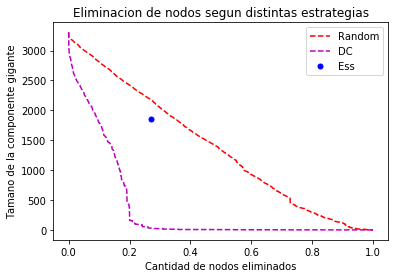

--- 259.5138432979584 seconds ---


In [406]:
start_time = time.time()
fig3(G,ess)
print("--- %s seconds ---" % (time.time() - start_time))